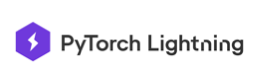


# VAE tutorial

Here we implement a VAE using Lightning.

⚡️ [The video tutorial is here](...)

⚡️ [Remember! we're always available for support on Slack](https://join.slack.com/t/pytorch-lightning/shared_invite/zt-f6bl2l0l-JYMK3tbAgAmGRrlNr00f1A)


---

# VAE Loss

The loss we'll be implementing for the VAE is called the ELBO.

$$
\color{red}{\min \mathbb{E}_{q}[ \log q(z|x) - \log p(z)]} - \color{blue}{\mathbb{E}_{q} \log p(x|z)}
$$

The first term is the KL-divergence and the second term the reconstruction.

For a full derivation and explanation see the next section


---

# Math

If you don't care about the derivation, please skip this part.

There are 2 ways to derive the VAE loss.

1. Using Jensen's inequality
2. Using KL divergence.

In this tutorial we'll use KL divergence.


## ELBO derivation

### What is the ELBO?

The result of this derivation is a loss called ELBO (evidence lower bound). The ELBO has two terms

Term 1: Reconstruction

$$
- \mathbb{E}_q \log p(x|z)
$$

Term 2: KL divergence

$$
\mathbb{E}_{q}  \log \frac{q(z|x)}{p(z)}
$$

Together, these two terms define the ELBO:

$$
- \mathbb{E}_{q}  \log p(x|z) + \mathbb{E}_{q}  \log \frac{q(z|x)}{p(z)}
$$


### ELBO as a bound

Minimizing KL divergence is equivalent to maximizing ELBO (with some slack).

This means that ELBO is a lowerbound on KL divergence.
Here's a rendering of what we mean by this in abstract terms

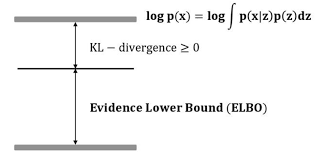


---

### How we get ELBO

Here's how we end up finding the ELBO.

First, remember we want to model a distribution over inputs, $ p(x) $. These can be images, etc...

We assume that there are factors that influence x but that we can't observe. We call these _latent_ variables. We use $z$ to refer to these.

So, by using marginalization, we can rewrite this as

$$
p(x) = \int_z p(x|z)dz
$$

Marginalization is just fancy for summing over a variable.
Here's an example using a discrete probability distribution.

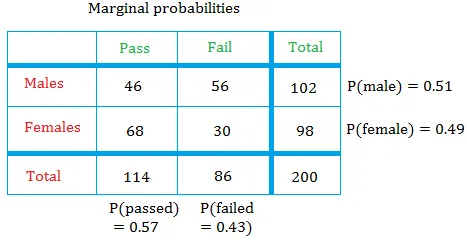


So, the joint model that uses $z$ variables to explain $x$ is defined by:

$$
p(x,z) = p(z|x)p(x)\\
\frac{p(x,z)}{p(x)} = p(z|x)
$$

But again, we find the $p(x)$ term at the bottom

To solve this we define $q(z|x)$ to approximate $p(z|x)$. $q$ is called the approximate posterior and $p$ the true posterior


Now this is starting to look like something we can do with machine learning. We have a source ($p$) and a target ($q$). We can treat this as an optimization problem where we parametrize $q$ (ie: a neural network) to try to get close to $p$ via gradient descent.

This is called variational inference (in general).

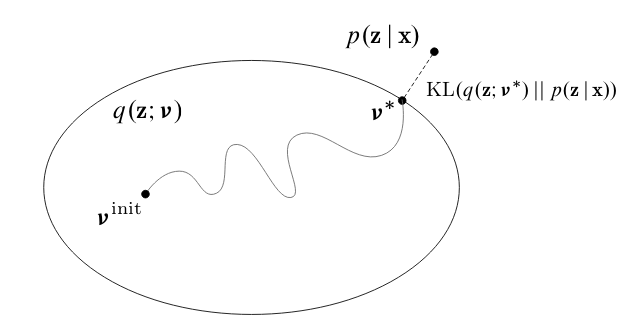


### KL divergence definition

The distance to minimize is called the KL divergence.
When we minimize the KL divergence, our $q$ will be an estimator of $p$.

This is the definition for the KL divergence between two distributions P, Q:

$$
D_{KL}(Q||P) = \sum Q \log \frac{Q}{P}
$$

We'll replace Q, P with our distributions $P = p(z|x)$ and $Q = q(z|x)$

$$
D_{KL}(q(z|x)||p(z|x)) = \sum q(z|x) \log \frac{q(z|x)}{p(z|x)}
$$


#### Sidenote about probability notation

I know using notation like $p(x)$ is confusing for those new to probability theory, but it is just a placeholder that stands for any distribution we want.
For example, $p(x)$ can be a Normal distribution, or a poisson, or any of the dozens of distributions available. It makes the math easier to manipulate simple letters with a few properties from probability theory


### ELBO derivation from KL(Q||P)

So, let's just play around with KL to see what comes out of the other end

\begin{align}
D*{KL}(q(z|x)||p(z|x)) &= \sum q(z|x) \log \frac{q(z|x)}{p(z|x)}\\
&= -\sum q(z|x) \log \frac{p(z|x)}{q(z|x)}\\
&= -\sum q(z|x) \left[\log p(z|x) - \log q(z|x) \right]\\
&= -\sum q(z|x) \left[\log \frac{p(x|z)p(z)}{p(x)} - \log q(z|x) \right]\\
&= -\sum q(z|x) \left[\log p(x|z) + \log p(z) - \log p(x) - \log q(z|x) \right]\\
&= \sum q(z|x) \left[-\log p(x|z) - \log p(z) + \log p(x) + \log q(z|x) \right]\\
D*{KL}(q(z|x)||p(z|x)) - \sum q(z|x) \left[-\log p(x|z) - \log p(z) + \log q(z|x) \right] &= \log p(x)\\
-\sum q(z|x) \left[-\log p(x|z) + \log \frac{q(z|x)}{p(z)} \right] &= \\
-\mathbb{E}_{z \sim q(z|x)} \left[-\log p(x|z) + \log \frac{q(z|x)}{p(z)} \right] &=\\
-\mathbb{E}_{q} \left[-\log p(x|z) + \log \frac{q(z|x)}{p(z)} \right] &=\\
\mathbb{E}_{q} \left[\log p(x|z) - \log \frac{q(z|x)}{p(z)} \right] &=\\
D_{KL}(q(z|x)||p(z|x)) + \left[ \mathbb{E}_{q} \log p(x|z) - \mathbb{E}_{q} \log \frac{q(z|x)}{p(z)} \right] &= \log p(x)\\
\end{align}


### Neural network loss

To maximize the ELBO, we can minimize the negative of the ELBO.

$$
\max \mathbb{E}_{q} \log p(x|z)  - \mathbb{E}_{q}  \log \frac{q(z|x)}{p(z)} =
\min  - [\mathbb{E}_{q} \log p(x|z)  - \mathbb{E}_{q}  \log \frac{q(z|x)}{p(z)}]
$$


### Monte carlo loss

\begin{align}
-\mathbb{E}_{q} \log p(x|z) + \mathbb{E}_{q}[ \log q(z|x) - \log p(z)]&= \\
\mathbb{E}_{q}[ \log q(z|x) - \log p(z)] - \mathbb{E}_{q} \log p(x|z)&=
\end{align}


The end result is:

\begin{align}
D*{KL}(q(z|x)||p(z|x)) + \left[ \mathbb{E}*{q} \log p(x|z) - \mathbb{E}\_{q} \log \frac{q(z|x)}{p(z)} \right] &= \log p(x)
\end{align}

The first term is the original $D_{KL}$ we want to minimize, ($D_{KL}(q(z|x)||p(z|x))$). The second term is called the variational lower bound (ELBO).

$$
\max \mathcal{L} = \mathbb{E}_{q} \log p(x|z)  - \mathbb{E}_{q}  \log \frac{q(z|x)}{p(z)}
$$

Since $\log p(x)$ is a constant, and we want to minimize the $D_{KL}$ term, we can achieve the same by maximizing the ELBO.


So, the end goal is to minimize this function:

$$
\color{red}{\min \mathbb{E}_{q}[ \log q(z|x) - \log p(z)]} - \color{blue}{\mathbb{E}_{q} \log p(x|z)}
$$


### Other implementations

Here's where a disconnect might happen. For most tutorials, the tutorials assume that $p(z)$ (the prior) is gaussian and also assumes that $p(z|x)$ is also gaussian.

So, most tutorials end up with a KL divergence that looks like:

$$
-0.5 \sum{1 \log{(\sigma)} - \mu^2 - e^{\log{(\sigma)}}}
$$


But in our case, we won't do that because we want to retain the flexibility to modify distributions as needed.

And since we don't know the KL between all possible pairs of distributions, we'll actually just use monte-carlo sampling for this.

Recall that:

$$
\mathbb{E}_p = \frac{1}{N}\sum_{}p(x)
$$

So, anywhere we see $\mathbb{E}_q$ we will draw a sample from q and use it in the formula.


In [ ]:
import torch

q = torch.distributions.Normal(2, 5)

z = q.rsample()
print(z)

## KL divergence intuition

Here we show the intuition of minimizing the KL


In [ ]:
p = torch.distributions.Normal(0, 1)
q = torch.distributions.Normal(2, 4)

log_pz = p.log_prob(z)
log_qzx = q.log_prob(z)

print('log prob pz: ', log_pz, 'prob:', torch.exp(log_pz))
print('log prob qzx: ', log_qzx, 'prob:', torch.exp(log_qzx))

In [ ]:
kl_divergence = log_qzx - log_pz
kl_divergence

now, if we manually move q closer to p, we see that this distrance has shrunk.


In [ ]:
# old q = torch.distributions.Normal(2, 4)
q = torch.distributions.Normal(1, 2)

log_qzx = q.log_prob(z)
print('log prob qzx: ', log_qzx, 'prob:', torch.exp(log_qzx))

new kl


In [ ]:
new_kl_divergence = log_qzx - log_pz
new_kl_divergence

---

## Implementation walk-through

So, with our formula defined, let's start our implementation.

If you skipped the math and elbo derivation, remember we are implementing this loss (the ELBO)

$$
\color{red}{\min \mathbb{E}_{q}[ \log q(z|x) - \log p(z)]} - \color{blue}{\mathbb{E}_{q} \log p(x|z)}
$$


In [ ]:
%%capture
! pip install pytorch-lightning
! pip install pytorch-lightning-bolts==0.2.5rc1

#### First 4 elements

The main 4 elements of a VAE are:

- encoder
- decoder
- mu
- sigma

mu, sigma are the parameters for the distributions in our formula.

Note: in our notation we say $q(z|x)$ where we assume $q$ to be a neural network. However, q is a neural network that DOES NOT GENERATE z. Instead it generates parameters FOR a distribution OVER z.


In [ ]:
import pytorch_lightning as pl
from torch import nn
from torch.nn import functional as F
from pl_bolts.models.autoencoders.components import (
    resnet18_decoder,
    resnet18_encoder,
)


class VAE(pl.LightningModule):
    def __init__(self, enc_out_dim=512, latent_dim=256, input_height=32):
        super().__init__()

        self.save_hyperparameters()

        # encoder, decoder
        self.encoder = resnet18_encoder(False, False)
        self.decoder = resnet18_decoder(latent_dim=latent_dim,
                                        input_height=input_height,
                                        first_conv=False,
                                        maxpool1=False)

        # distribution parameters
        self.fc_mu = nn.Linear(enc_out_dim, latent_dim)
        self.fc_var = nn.Linear(enc_out_dim, latent_dim)

#### Sample z

In Lightning we define the model interactions and the core algorithm in the training_step.

For EDUCATIONAL purposes only, we are adding the training_step to the lightning module here instead of in the original class definition

The VAE algorithm goes like this:

1. Sample z


In [ ]:
vae = VAE()

In [ ]:
# DATA
# we're pretending to have an image from cifar-10 (3 channels, 32x32 pixels)
x = torch.rand(1, 3, 32, 32)

print('image shape:', x.shape)

# GET Q(z|x) PARAMETERS
# encode x to get the mu and variance parameters
x_encoded = vae.encoder(x)
mu, log_var = vae.fc_mu(x_encoded), vae.fc_var(x_encoded)

print('mu:', mu.shape)
print('log_var:', log_var.shape)

# SAMPLE Z from Q(Z|x)
std = torch.exp(log_var / 2)
q = torch.distributions.Normal(mu, std)
z = q.rsample()

print('z shape:', z.shape)

In [ ]:
zero = torch.zeros_like(mu)
one = torch.ones_like(std)
p = torch.distributions.Normal(zero, one)

#### decoding

The second part is reconstruction.

The decoder is going to take as input $z$ and it will generate PARAMETERS for a distribution from which to sample a reconstruction.

Note: Most tutorials use MNIST so the decoder generates BERNOULLI variables which can be used in a bernoulli distribution to sample a value for each pixel.

That's right, the decoder generates distribution parameters FOR EACH pixel. And since most tutorials use MNIST the outputs of the decoder will LOOK like a digit because those parameters are in the range 0-1 (which happens to be the same for black and white images).


But in our case, we'll actually use CIFAR-10 which are color images... so we need to do something more realistic:


In [ ]:
x_hat = vae.decoder(z)
print(x_hat.shape)

#### reconstruction loss

You'll likely see the reconstruction loss using MSE like this in most tutorials about autoencoders.

However, MSE DOES not apply to Variational autoencoders


In [ ]:
recon_loss = F.mse_loss(x_hat, x, reduction='none')
recon_loss = recon_loss.sum(-1).sum(-1).sum(-1)
print('wrong reconstruction loss', recon_loss)

Instead, the output of the decoder represents parameters for a distribution.

When the images are MNIST, the parameters (decoder output) can be considered bernoullis and thus you can use the pixel values of MNIST (because they are ones and zeros) to calculate the cross entropy (which is the "reconstruction loss").

But when dealing with color images, it is prefered to model each parameter out of the decoder as a gaussian.


In [ ]:
# get the PARAMETERS for P(x|z)
x_hat = vae.decoder(z)
print('we have these many parameters for a distribution:', x_hat.shape)

# compute the probability of x under this n-dimensional distribution
log_scale = nn.Parameter(torch.Tensor([0.0]))
scale = torch.exp(log_scale)
dist = torch.distributions.Normal(x_hat, scale)
log_pxz = dist.log_prob(x)

print(log_pxz.shape)

# sum across channels, and all pixels (width, height)
# this gives the log probability of THIS particular IMAGE
log_pxz = log_pxz.sum(dim=(1, 2, 3))
print(log_pxz.shape)
print('reconstruction loss:', log_pxz.item())

recon_loss = log_pxz

#### kl divergence

Next we'll define the second term of the loss which is the KL divergence.

Now, we don't want to compute the KL divergence analytically, so we'll instead use the monte carlo estimate.

$$
= \mathbb{E}_{q}  \log \frac{q(z|x)}{p(z)}\\
= \mathbb{E}_{q} [\log q(z|x) - \log{p(z)}]
$$

To code this, we'll need to be able to get the probability of z under each of $p(z)$ and $q(z|x)$.

This means we don't need to know what the distribution is, but only sample from it.


In [ ]:
# 1. define the first two probabilities (in this case Normal for both)
p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
q = torch.distributions.Normal(mu, std)

# 2. get the probabilities from the equation
log_qzx = q.log_prob(z)
log_pz = p.log_prob(z)

print(log_qzx.shape, log_pz.shape)

# 3. calculate the KL
kl = (log_qzx - log_pz)

# 4. this bit is a bit tricky. Since these are log probabilities
# we can sum all the individual dimensions to give us the multi-dimensional
# probability
kl = kl.sum(-1)
print(kl)

#### ELBO

So, the full elbo is:


In [ ]:
elbo = (kl - recon_loss)
print('kl:', kl.mean())
print('log likelihood (reconstruction loss):', recon_loss.mean())
print('elbo: ', elbo.mean())

# Full Implementation

So, the full implementation is as follows.


In [ ]:
import pytorch_lightning as pl
from torch import nn
from torch.nn import functional as F
from pl_bolts.models.autoencoders.components import (
    resnet18_decoder,
    resnet18_encoder,
)
import torch


class VAE(pl.LightningModule):
    def __init__(self, enc_out_dim=512, latent_dim=256, input_height=32):
        super().__init__()

        self.save_hyperparameters()

        # encoder, decoder
        self.encoder = resnet18_encoder(False, False)
        self.decoder = resnet18_decoder(latent_dim=latent_dim,
                                        input_height=input_height,
                                        first_conv=False,
                                        maxpool1=False)

        # distribution parameters
        self.fc_mu = nn.Linear(enc_out_dim, latent_dim)
        self.fc_var = nn.Linear(enc_out_dim, latent_dim)

        # for the gaussian likelihood
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)

    def gaussian_likelihood(self, mean, logscale, sample):
        scale = torch.exp(logscale)
        dist = torch.distributions.Normal(mean, scale)
        log_pxz = dist.log_prob(sample)
        return log_pxz.sum(dim=(1, 2, 3))

    def kl_divergence(self, z, mu, std):
        # --------------------------
        # Monte carlo KL divergence
        # --------------------------
        # 1. define the first two probabilities (in this case Normal for both)
        p = torch.distributions.Normal(torch.zeros_like(mu),
                                       torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)

        # 2. get the probabilities from the equation
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        # kl
        kl = (log_qzx - log_pz)
        kl = kl.sum(-1)
        return kl

    def training_step(self, batch, batch_idx):
        # print(batch)
        x, _ = batch

        # encode x to get the mu and variance parameters
        x_encoded = self.encoder(x)
        mu, log_var = self.fc_mu(x_encoded), self.fc_var(x_encoded)

        # sample z from q
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()

        # decoded
        x_hat = vae.decoder(z)

        # reconstruction loss
        recon_loss_ = self.gaussian_likelihood(x_hat, self.log_scale, x) # old recon_loss 
        # print(recon_loss.shape)
        recon_loss = torch.nn.MSELoss()(x_hat,x)
        # print(recon_loss.shape)

        # kl
        kl = self.kl_divergence(z, mu, std)

        # elbo
        elbo = (kl - recon_loss_) # with old recon_loss
        # elbo = (kl + recon_loss)
        elbo = elbo.mean()

        self.log_dict({
            'elbo': elbo,
            'kl': kl.mean(),
            'recon_loss_': recon_loss.mean(),
            'recon_loss': recon_loss_.mean(),
            'reconstruction': recon_loss.mean(),
            'kl': kl.mean(),
        })

        return elbo

Let's use CIFAR-10 already split up and transformed.

The Lightning Datamodule has 3 dataloaders, train, val, test


In [ ]:
import torch.utils.data as data
import numpy as np
import datetime
from os import listdir
import random
from os.path import join
from os.path import basename
from PIL import Image
import h5py

class wss_dataset_class(data.Dataset):
    def __init__(self,
                 root_dir,
                 split,
                 transform=None,
                 preload_data=False,
                 train_pct=0.8,
                 balance=True):
        super(wss_dataset_class, self).__init__()
        #train dir
        img_dir = root_dir

        self.image_filenames = sorted(
            [join(img_dir, x) for x in listdir(img_dir) if is_image_file(x)])
        self.target_filenames = [
            list(
                map(int, [
                    x.split('-')[-1][:-4][1],
                    x.split('-')[-1][:-4][4],
                    x.split('-')[-1][:-4][7]
                ])) for x in self.image_filenames
        ]
        sp = self.target_filenames.__len__()
        sp = int(train_pct * sp)
        # random.shuffle(self.image_filenames)
        if split == 'train':
            self.image_filenames = self.image_filenames[:sp]
        elif split == 'all':
            self.image_filenames = self.image_filenames
        else:
            self.image_filenames = self.image_filenames[sp:]
            # find the mask for the image
            self.target_filenames = self.target_filenames[sp:]
            print(len(self.target_filenames))
        print('Number of {0} images: {1} patches'.format(
            split, self.__len__()))
        assert len(self.image_filenames) == len(self.target_filenames)

        # report the number of images in the dataset

        # data augmentation
        self.transform = transform

        # data load into the ram memory
        self.preload_data = preload_data
        if self.preload_data:
            print('Preloading the {0} dataset ...'.format(split))
            self.raw_images = [
                open_image_np(ii)[0] for ii in self.image_filenames
            ]
            print('Loading is done\n')

    def __getitem__(self, index):
        # update the seed to avoid workers sample the same augmentation parameters
        np.random.seed(datetime.datetime.now().second +
                       datetime.datetime.now().microsecond)
        target = self.target_filenames[index]
        if sum(target) == 2:
            target = 0#3
        else:
            target = np.array(target).argmax()
        # load the nifti images
        if not self.preload_data:
            input = open_image_np(self.image_filenames[index])
        else:
            input = np.copy(self.raw_images[index])

        # handle exceptions
        if self.transform:
            input = self.transform(input)

        return input, target

    def __len__(self):
        return len(self.image_filenames)


def is_image_file(filename):
    return any(
        filename.endswith(extension)
        for extension in [".nii.gz", 'png', 'tiff', 'jpg', "bmp"])


def open_image(filename):
    """
    Open an image (*.jpg, *.png, etc).
    Args:
    filename: Name of the image file.
    returns:
    A PIL.Image.Image object representing an image.
    """
    image = Image.open(filename)
    return image


def open_image_np(path):
    im = open_image(path)
    array = np.array(im)
    return array
class HDF5Dataset(data.Dataset):
    """
    Load an HDF5 dataset.
    Args:
    path_train: Path to the HDF5 file.
    path_train_y: Path to the HDF5 file labels.
    transform
    """
    def __init__(self, path,path_y, transform=None, limit=False):
        super(HDF5Dataset, self).__init__()
        self.path = path
        self.path_y = path_y
        self.limit = limit
        self.transform = transform
    def __getitem__(self, index):
        with h5py.File(self.path, 'r') as hf:
            input = hf['x'][index]
        with h5py.File(self.path_y, 'r') as hf:
            target = hf['y'][index].squeeze()
        if self.transform:
            input = self.transform(input)
        return input, torch.tensor(target)
    def __len__(self):
        if self.limit is not False:
            return self.limit
        with h5py.File(self.path, 'r') as hf:
            return len(hf['x'])

In [ ]:
from torchvision import transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomResizedCrop((32, 32)),
    transforms.ConvertImageDtype(torch.float),
])
data = wss_dataset_class("/home/uz1/data/wsss/train/1.training", 'all',
                         transform)
data = HDF5Dataset("/home/uz1/DATA!/pcam/pcam/training_split.h5","/home/uz1/DATA!/pcam/Labels/Labels/camelyonpatch_level_2_split_train_y.h5",transform=transform)
loader = DataLoader(data, batch_size=32, drop_last=True, num_workers=16)


In [ ]:
data[4][0].shape

In [ ]:
val_data = wss_dataset_class("/home/uz1/data/wsss/train/1.training",
                                    'valid', transform)
val_loader = DataLoader(data, batch_size=16, drop_last=True, num_workers=16)
len(val_data)

In [ ]:
# lr logging
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from callbacks import TestReconCallback
import os

callbacks = []
lr_monitor = LearningRateMonitor(logging_interval="epoch")
callbacks.append(lr_monitor)

# save checkpoint on last epoch only
ckpt = ModelCheckpoint("/home/uz1/projects/GCN/logging/",
                       monitor="elbo",
                       save_weights_only=True)
callbacks.append(ckpt)

# add test for mid-train recon viewing
test = [data[x][0] for x in range(16)]
test = torch.stack(test, 0)
testRecon = TestReconCallback(test)
callbacks.append(testRecon)


Now we train!


In [ ]:
pl.seed_everything(1234)

vae = VAE(input_height=data[0][0].shape[1], latent_dim=1024)
trainer = pl.Trainer(gpus=1,
                     max_epochs=500,
                     progress_bar_refresh_rate=10,
                     callbacks=callbacks)
# vae = vae.load_from_checkpoint("/home/uz1/projects/GCN/logging/final.cpkt")
vae = vae.load_from_checkpoint("/home/uz1/projects/GCN/logging/epoch=461-step=145529.ckpt")
trainer.fit(vae, loader)


In [ ]:

vae = VAE(input_height=data[0][0].shape[1], latent_dim=1024)
vae = vae.load_from_checkpoint("/home/uz1/projects/GCN/logging/epoch=20-step=172031.ckpt")

## Plot an image


In [ ]:
from matplotlib.pyplot import imshow, figure
import numpy as np
from torchvision.utils import make_grid
from pl_bolts.transforms.dataset_normalizations import cifar10_normalization

figure(figsize=(8, 3), dpi=300)
# real teest data
num_preds = 16
test = [data[x][0] for x in range(num_preds)]
test = torch.stack(test, 0).to(vae.device)
x_encoded = vae.encoder(test)

mu, log_var = vae.fc_mu(x_encoded), vae.fc_var(x_encoded)
std = torch.exp(log_var / 2)
# Z COMES FROM NORMAL(0, 1)
p = torch.distributions.Normal(mu, std)
z = p.rsample()

# SAMPLE IMAGES
with torch.no_grad():
    pred = vae.decoder(z.to(vae.device)).cpu()

# UNDO DATA NORMALIZATION
# normalize = cifar10_normalization()
# mean, std = np.array(normalize.mean), np.array(normalize.std)
img = make_grid(pred).permute(1, 2, 0).numpy() * 1  # std + mean

# PLOT IMAGES
imshow(img)

figure(figsize=(8, 3), dpi=300)
img_ = make_grid(test).permute(1, 2, 0).numpy() * 1  # std + mean
imshow(img_)

In [ ]:
#view samples in test set
img = make_grid(test).permute(1, 2, 0).numpy() * 1  # std + mean
imshow(img)


In [ ]:
from torchvision.transforms import ToPILImage

pil = ToPILImage()

#random sampling from latent space  - random points from space
figure(figsize=(8, 3), dpi=300)
mu = torch.rand((16, 1024))
std = torch.rand((16, 1024))
p = torch.distributions.Normal(mu, std)
z = p.rsample()
img = vae.decoder(z)

img = make_grid(img).permute(1, 2, 0).numpy() * 1  # std + mean
imshow(img)

In [ ]:
#random sampling from latent space - from same distribution get N samples
figure(figsize=(8, 3), dpi=300)
mu = torch.rand((1, 1024))
std = torch.rand((1, 1024))
p = torch.distributions.Normal(mu, std)
z = p.rsample((16, ))
img = vae.decoder(z)

img = make_grid(img).permute(1, 2, 0).numpy() * 1  # std + mean
imshow(img)

In [ ]:
import matplotlib.pyplot as plt

num_points = 1000
# real test data  -  vis of means of data and class clusters
test = [data[x][0] for x in range(num_points)]
y_test = [data[x][1] for x in range(num_points)]
test = torch.stack(test, 0).to(vae.device)
x_encoded = vae.encoder(test)

mu, _ = vae.fc_mu(x_encoded), vae.fc_var(x_encoded)
mu = mu.detach().cpu().numpy()
# std = torch.exp(log_var / 2

#Plot dim1 and dim2 for mu
plt.figure(figsize=(10, 10))
plt.scatter(mu[:, 0], mu[:, 1], c=y_test, cmap='brg')
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.colorbar()
plt.show()

In [ ]:
np.linspace(mu, mu + 30, 30).shape


In [ ]:
# Display a 2D manifold of the digits
n = 8  # figure with 30x30 digits
digit_size = 32
figure = np.zeros((digit_size * n, digit_size * n))

x = data[2][0].unsqueeze(0)
x_encoded = vae.encoder(x)
mu, log_var = vae.fc_mu(x_encoded), vae.fc_var(x_encoded)
# SAMPLE Z from Q(Z|x)
std = torch.exp(log_var / 2).detach().cpu()
mu = mu.detach().cpu()

# We will sample n points within [-1.5, 1.5] standard deviations
grid_x = torch.tensor(np.linspace(mu, mu, n))
grid_y = torch.tensor(np.linspace(std, std, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        # z_sample = np.array([[xi, yi]])
        # print(xi.shape,yi.shape)
        # Generate an image using a decoder model
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()
        x_decoded = vae.decoder(z).detach().cpu().numpy()
        #x_decoded = np.clip(x_decoded, 0.25, 0.75) # we could use cliping to make digit edges thicker

        # Reshape from 784 to original digit size (28x28)
        digit = x_decoded.reshape(digit_size, digit_size, 3)

        figure[i * digit_size:(i + 1) * digit_size, j * digit_size:(j + 1) *
               digit_size] = digit[:, :, :1].squeeze()

# Plot figure
plt.figure(figsize=(18, 16))
plt.imshow(figure)
plt.show()

In [ ]:
torch.distributions.Normal(torch.tensor(xi), torch.tensor(yi))


In [ ]:
# DATA
# we're pretending to have an image from cifar-10 (3 channels, 32x32 pixels)
x = data[1][0].unsqueeze(0)

print('image shape:', x.shape)

# GET Q(z|x) PARAMETERS
# encode x to get the mu and variance parameters
x_encoded = vae.encoder(x)
mu, log_var = vae.fc_mu(x_encoded), vae.fc_var(x_encoded)

print('mu:', mu.shape)
print('log_var:', log_var.shape)

# SAMPLE Z from Q(Z|x)
std = torch.exp(log_var / 2)
q = torch.distributions.Normal(mu, std)
z = q.rsample()

print('z shape:', z.shape)

In [ ]:
trainer.save_checkpoint("/home/uz1/projects/GCN/logging/final.cpkt")

In [ ]:
a = imshow(img)

In [ ]:
figure

In [ ]:
np.array()

In [ ]:
pil(img)

In [ ]:
len(data)

# K-Means!


In [ ]:
num_points = 20000
# real test data  -  vis of means of data and class clusters
test = [data[x][0] for x in range(num_points)]
y_test = [data[x][1] for x in range(num_points)]
test = torch.stack(test, 0).to(vae.device)
x_encoded = vae.encoder(test)

mu, log_var = vae.fc_mu(x_encoded), vae.fc_var(x_encoded)
std = torch.exp(log_var / 2)
q = torch.distributions.Normal(mu, std)
z = q.rsample()
z=z.detach().cpu().numpy()
print(z.shape)

In [ ]:
from sklearn.cluster import KMeans
import math
x_em = z
k=KMeans(n_clusters=4).fit(x_em)
k.labels_.shape

In [ ]:
del mu
del log_var
del std
del z

In [ ]:
import pickle
with open("kmeans-model-4.pkl", "wb") as f:
    pickle.dump(k, f)
del test
with open("kmeans-model-4.pkl", "rb") as f:
    k = pickle.load(f)

In [ ]:
zs.shape,labels.shape

In [ ]:
from torch.utils.tensorboard.writer import SummaryWriter
writer = SummaryWriter("/home/uz1/projects/GCN/lightning_logs")
import datetime

now = datetime.datetime.now()

current_time = now.strftime("%H:%M:%S")
writer.add_embedding(z.reshape(-1,1024)[:6000],k.labels_.reshape(-1)[:6000],global_step=current_time)

In [ ]:
#Plot dim1 and dim2ss for mu

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.scatter(z[:, 0], z[:, 1], c=k.labels_, cmap='brg')
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.colorbar()
plt.show()

# Trial - Graph Foramtion - Just on Patches
#### Make a patch of orginal dimention subsampled into samller patches
#### Project these patches using VAE
#### get their assigned cluster number based on the KMeans classifier 


Also need a way to store the Kmeans classifier as a outside file to load on inference 


In [ ]:
#load images to be patched 
from torchvision import transforms
from torch.utils.data import DataLoader
## images as 128x128 to 16 patches (each 32x32)
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.RandomResizedCrop((128,128)),
    transforms.ConvertImageDtype(torch.float),
    transforms.Resize((128,128)),
])
data_128 = wss_dataset_class("/home/uz1/data/wsss/train/1.training", 'all',
                         transform)
data_128 = data
data_128.transform = transform
data_128.limit=30000
loader = DataLoader(data_128, batch_size=32, drop_last=True, num_workers=16)






In [ ]:
len(data_128)

In [ ]:
test_128 = [x[0] for x in data_128]

In [ ]:
test_128[1].shape

In [ ]:
from torchvision.transforms import ToPILImage,ToTensor
from matplotlib.pyplot import imshow, figure
import numpy as np
from torchvision.utils import make_grid
from skimage import graph, io, segmentation, color
from matplotlib import pyplot as plt
import pickle
from torch_geometric.utils import to_dense_adj, grid,dense_to_sparse
from monai.data import GridPatchDataset, DataLoader, PatchIter
patch_iter = PatchIter(patch_size=(32, 32), start_pos=(0, 0))
#patching each image
with open("kmeans-model-4.pkl", "rb") as f:
    k = pickle.load(f)
pil = ToPILImage()
to_tensor=ToTensor()
patches = []
coords=[]
#pick a random number
n=np.random.randint(0,len(data_128))
#iterate over image patches 
img=data_128[n][0]
# z = zs[n]
print("target = ",data_128[n][1])
for x in patch_iter(img):
	patches.append(x[0])
	coords.append(x[1])


def get_embedding_vae(x,vae):

	x_encoded = vae.encoder(x)
	mu, log_var = vae.fc_mu(x_encoded), vae.fc_var(x_encoded)
	std = torch.exp(log_var / 2)
	q = torch.distributions.Normal(mu, std)
	z = q.rsample()
	return z 

patches = torch.stack([torch.tensor(patches)],0).squeeze()
#embed using model 
z=get_embedding_vae(patches,vae).detach().cpu().numpy()
	#kmean cluster find 
label = k.predict(z)# B,d

#show patches grid
# img = make_grid(patches,nrow = 4).permute(1, 2, 0).numpy()
# imshow(img)




labels_ = np.zeros((128,128))
#generate label map for whole image 
for l, coord in zip(label,coords):
	labels_[coord[1][0]:coord[1][1],coord[2][0]:coord[2][1]] = l

img = np.array(pil(img))
label_rgb = color.label2rgb(labels_, img, kind='overlay')
# imshow(label_rgb)

imgs = torch.stack([to_tensor(img),to_tensor(label_rgb)],0)
img = make_grid(imgs,nrow = 4).permute(1, 2, 0).numpy()
imshow(img),label.reshape(4,4)

In [ ]:
def populateS(labels,shape=(16,8),s=None):
    """"
    Calculates the S cluster assigment transform of input patch features 
    and returns the (S) and the aggregated (out_adj) as well.
    """
    # print("S is " ,s==None)
    if s == None: 
        s= np.zeros(shape)
        for i in range(s.shape[0]):
            s[i][labels[i]] = 1
    else:
        s=s
    
    #calc adj matrix
    adj = to_dense_adj(grid(shape[0]//4,shape[0]//4)[0]).reshape(shape[0],shape[0])
    return s , np.matmul(np.matmul(s.transpose(1, 0),adj ), s)
s ,out_adj= populateS(label)
zz=np.matmul(s.transpose(1,0) , z)

In [ ]:
out_adj.div(out_adj.sum(1)),out_adj # for each cluster - the row describes how for the cluster - How many times it was adjacent to the other clusters 

In [ ]:
dense_to_sparse(out_adj)[0].reshape(43,-1)

In [ ]:
np.unique(label)

In [ ]:
zz.shape

In [ ]:
s,zz[3]

In [ ]:
to_dense_adj(grid(4,4)[0]).shape

In [ ]:
adj = to_dense_adj(grid(4,4)[0]).reshape(16,16)
out_adj =np.matmul(np.matmul(s.transpose(1, 0),adj ), s)

In [ ]:
def calculate_cluster_dist_stat(label):
    s = torch.zeros(16,8)   
    label=label+1
    l=label.copy()
    for i in range(16):
        print(label.reshape(4,4))
        l[i]=0
        unique_n = torch.unique(a[i].reshape(4,4) * l.reshape(4,4),return_counts=True)
        no_n = sum(unique_n[1][1:])
        print(torch.unique(a[i].reshape(4,4) * l.reshape(4,4),return_counts=True) ,no_n,l[i],)
        perc_n = unique_n[1][1:]/no_n

        w = torch.zeros(8,)
        w[unique_n[0][1:].long()-1] = perc_n
        s[i] = w
    return s
calculate_cluster_dist_stat(label)


In [ ]:
print("embedding shape: ",z.shape)
img = vae.decoder(to_tensor(z).squeeze())
print("Output of decoder shape: ",img.shape)

img = make_grid(img,nrow = 4).permute(1, 2, 0).numpy()
imshow(img)

In [ ]:
import numpy as np

from monai.data import GridPatchDataset, DataLoader, PatchIter

#patch yeilding 



# image-level dataset
images = data_128
# image-level patch generator, "grid sampling"
patch_iter = PatchIter(patch_size=(32, 32), start_pos=(0, 0))
# patch-level intensity shifts
# patch_intensity = RandShiftIntensity(offsets=1.0, prob=1.0)

# construct the dataset
ds = GridPatchDatasetWithLabels(data=images,
                      patch_iter=patch_iter,)
# use the grid patch dataset
# for item in DataLoader(ds, batch_size=2, num_workers=2):
#     print("patch size:", item[0].shape)
#     print("coordinates:", item[1])

# >>> patch size: torch.Size([2, 1, 2, 2])
#     coordinates: tensor([[[0, 1], [0, 2], [0, 2]],
#                          [[0, 1], [2, 4], [0, 2]]])

In [ ]:

# Install required packages.
import os
import torch 
# Helper function for visualization.
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

from torch_geometric.data import Data,Dataset

def visualize_graph(G, pos,nodelist=None,edgecolor=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, with_labels=True,
                      cmap="viridis",  node_size=200,nodelist = nodelist,edge_color=edgecolor,edge_vmin=0,edge_vmax=10)
    plt.show()


def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16,color='white')
    plt.show()
pos_dict = {e:[k,v] for e,(k,v) in enumerate(grid(3,3)[1])}


# data=train_dataset[2]
d= Data(x=zz,edge_index=dense_to_sparse(out_adj)[0],edge_attr=dense_to_sparse(out_adj)[1])
G = to_networkx(d, to_undirected=False)
visualize_graph(G, pos=pos_dict,nodelist=list(torch.unique(d.edge_index[0]).numpy()),edgecolor=list(d.edge_attr.numpy())) 

In [ ]:
dense_to_sparse(out_adj)[1],dense_to_sparse(out_adj)[0]

## Build a GCN 
#### Cluster assignment given using the KMEANS + edge features (statistics !?)
#### pool features using the assignmentinto cluster node features 
#### build and classify images  - somehow 	

In [ ]:
from tkinter import Label
from monai.data.iterable_dataset import IterableDataset
from monai.transforms import apply_transform
import numpy as np

from monai.data import GridPatchDataset, DataLoader, PatchIter

#patch yeilding 



# image-level dataset
images = data_128
# image-level patch generator, "grid sampling"
patch_iter = PatchIter(patch_size=(32, 32), start_pos=(0, 0))
# patch-level intensity shifts
# patch_intensity = RandShiftIntensity(offsets=1.0, prob=1.0)


class GridPatchDatasetWithLabels(IterableDataset):

    """
    Takes a list or Dataset of iamges and their labels 
    returns:
    Patchs , coords, image label
    """
    def __init__(
        self,
        data ,
        patch_iter ,
        transform=None,
        with_coordinates=True,
        kmeans=None,
    ) -> None:
        super().__init__(data=data, transform=None)
        self.patch_iter = patch_iter
        self.patch_transform = transform
        self.with_coordinates = with_coordinates

    def __iter__(self):
        for  image,label in super().__iter__():
            for patch, *others in self.patch_iter(image):
                out_patch = patch
                if self.patch_transform is not None:
                    out_patch = apply_transform(self.patch_transform, patch, map_items=False)
                if self.with_coordinates and len(others) > 0:  # patch_iter to yield at least 2 items: patch, coords
                    yield torch.tensor(out_patch), others[0],label
                else:
                    yield torch.tensor(out_patch),label
    
    def __getitem__(self, index):
        patches=[]
        coords=[]
        for patch,coord in self.patch_iter(self.data[index][0]):
            out_patch = patch
            if self.patch_transform is not None:
                out_patch = apply_transform(self.patch_transform, patch, map_items=False)
            patches.append(out_patch)
            coords.append(coord)
        return torch.stack([torch.tensor(patches)],0),coords,self.data[index][1]
                
# construct the dataset
ds = GridPatchDatasetWithLabels(data=images,
                      patch_iter=patch_iter,)

In [ ]:
def get_embedding_vae(x,vae):

	x_encoded = vae.encoder(x)
	mu, log_var = vae.fc_mu(x_encoded), vae.fc_var(x_encoded)
	std = torch.exp(log_var / 2)
	q = torch.distributions.Normal(mu, std)
	z = q.rsample()
	return z
#generate an embedding for each image in dataset 
zs=[]
labels =[]
for patches,coords,label in DataLoader(ds, batch_size=16, num_workers=8):
# for patches,coords,label in ds:
	# print(patches.shape,coords,label)
	z=get_embedding_vae(patches,vae).detach().cpu().numpy()
	label=k.predict(z)
	zs.append(z)	
	labels.append(label)	


print(len(zs),len(labels))


	

In [ ]:
zs.shape

In [ ]:
zss=torch.stack([torch.tensor(zs)],0)

In [ ]:
len(labels)

In [ ]:
labels = np.array(labels)

In [ ]:
zs = zss.reshape(-1,16,1024)

In [ ]:
zs.shape

In [ ]:
import h5py

ff = h5py.File('data1.h5', 'w')
N = zs.shape[0]
z=ff.create_dataset('zs', shape=(N, 16,1024), dtype=np.float32, fillvalue=0) #z
z=zs.numpy()
l=ff.create_dataset('labels', shape=(N, 16, ), dtype=np.float32, fillvalue=0) #labels
l=labels
print(z.shape,l.shape)
ff.close()

In [ ]:
ff.close()

In [ ]:
import h5py
ff = h5py.File('data1.h5', 'r')
zss = ff['zs']

In [ ]:
ff['labels'][2]

In [ ]:
len(labels)

In [ ]:
# The GCN process
'''

A gcn takes input the following:

features matrix N,F
adj Matrix N,D,D
Edge features ? - 

'''

def populateS(labels,shape=(16,8)):
    """"
    Calculates the S cluster assigment transform of input patch features 
    and returns the (S) and the aggregated (out_adj) as well.
    """
    s = np.zeros(shape) 

    for i in range(s.shape[0]):
        s[i][labels[i]] = 1
    
    #calc adj matrix
    adj = to_dense_adj(grid(shape[0]//4,shape[0]//4)[0]).reshape(shape[0],shape[0])
    return s , np.matmul(np.matmul(s.transpose(1, 0),adj ), s)

In [ ]:

from torch_geometric.data import Data,Dataset
from torch_geometric.utils import to_dense_adj, grid,dense_to_sparse
print("No embeddings : ",z.shape)
print("No data: ",len(data_128))

print(Data(x=z[1],edge_index = grid(16,16)[0],pos=grid(16,16)[1]))

def filter_a(data):

    if data.y==3:
        return False
    else:
        True

class ImageTOGraphDataset(Dataset):
    """ 
    Dataset takes holds the kmaens classifier and vae encoder. On each input image we encode then get k mean label then formulate graph as Data object
    """
    def __init__(self,data,vae,kmeans):
        self.data=data
        self.vae=vae
        self.kmeans=kmeans
        self.patch_iter = PatchIter(patch_size=(32, 32), start_pos=(0, 0))
    def __len__(self):
        return len(self.data)
    def __getitem__(self,index):
        
        patches = []
        for x in self.patch_iter(self.data[index][0]):
            patches.append(x[0])
            
        patches = torch.stack([torch.tensor(patches)],0).squeeze()

        z=get_embedding_vae(patches,self.vae).clone().detach().cpu().numpy()
        label=self.kmeans.predict(z)
        s,out_adj = populateS(label)
        x = np.matmul(s.transpose(1,0) , z)
        return Data(x=torch.tensor(x).float(),edge_index=dense_to_sparse(out_adj)[0],y=torch.tensor(self.data[index][1]),edge_attr=dense_to_sparse(out_adj)[1])

class KDataset(Dataset):
    
    """
    Dataset to store the cluster repr of images as embedding feature maps 
    and edge as a grid formation ? - not really we use cluster feature relations as a 

    """

    def __init__(self,zs,data_128,labels,root=None,transform=None,pre_transform=None,pre_filter=None):
        super(KDataset,self).__init__(root,transform,pre_transform,pre_filter)
        self.zs=zs
        self.data = data_128
        self.labels = labels
    

    def __getitem__(self,index):
        
        s,out_adj = populateS(self.labels[index])
        x = np.matmul(s.transpose(1,0) , self.zs[index])

        
        return Data(x=x,edge_index=dense_to_sparse(out_adj)[0],y=torch.tensor(self.data[index][1]),edge_attr=dense_to_sparse(out_adj)[1])
    def __len__(self):
        return len(self.zs)


ImData = ImageTOGraphDataset(data=data_128,vae=vae,kmeans=k)
train_loader = DataLoader(ImData, batch_size=16, shuffle=True, num_workers=0)



In [ ]:
# if zs is defined then use it else use data_128
if zs is not None:
    k_data = KDataset(zs,data_128,labels,pre_filter=filter_a)
    from torch_geometric.loader import DataLoader
    print("No final data: ",len(k_data))

    train_loader = DataLoader(k_data, batch_size=8, shuffle=True)
    for data in train_loader:
        print(data)
        break

In [ ]:
ImData[12]

In [ ]:
import torch
from torch.nn import Linear,Sequential
from torch_geometric.nn import GCNConv,GATConv,EdgeConv,DynamicEdgeConv
from torch_geometric.nn import global_mean_pool


class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
class GCN(torch.nn.Module):
    '''
    Can add edge_atttr using the second out of dense_to_sparse
    '''
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234)
        
        gcon = EdgeConv
        self.conv1 = gcon(Sequential(Linear(2*1024, 512)))

        self.conv2 =gcon(Sequential(Linear(2*512, 256)))#gcon(512, 256)
        self.conv3 =gcon(Sequential(Linear(2*256, 256)))#gcon(512, 256)
        self.conv4 =gcon(Sequential(Linear(2*256, 128)))#gcon(512, 256)
        self.conv5 =gcon(Sequential(Linear(2*128, 64)))#gcon(512, 256)
        self.conv6 =gcon(Sequential(Linear(2*64, 32)))#gcon(512, 256)
        self.classifier = Linear(32, 3)

    def forward(self, x, edge_index,batch):
        h = self.conv1(x, edge_index)
        h = h.relu()
        h = self.conv2(h, edge_index)
        h = h.relu()
        h = self.conv3(h, edge_index)
        h = h.relu()
        h = self.conv4(h, edge_index)
        h = h.relu()
        h = self.conv5(h, edge_index)
        h = h.relu()
        h = self.conv6(h, edge_index)
        # h = h.tanh()  # Final GNN embedding space.
        h = global_mean_pool(h,batch)  # [batch_size, hidden_channels]

        # Apply a final (linear) classifier.
        out = self.classifier(h)

        return out#, h

model = GCN()
print(model)

In [ ]:
model = GCN()
# data = k_data[0]
# print(data)
# out = model(ImData.x.float(), data.edge_index,data.batch)
# print(f'Embedding shape: {list(out.shape)}')

import time
from tqdm import tqdm
from torch_geometric.loader import DataLoader
from torch_geometric.nn.models import GraphUNet
from torch.functional import F
# model = GraphUNet(9,128,2,4,act=F.tanh)
criterion = torch.nn.CrossEntropyLoss(torch.tensor([.2,.2,.8]))  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)  # Define optimizer.
data_laoder = train_loader
def train(data):
    optimizer.zero_grad()  # Clear gradients.
    # print(data)
    out = model(data.x, data.edge_index,data.batch)#,data.edge_weight.float())  # Perform a single forward pass.
    # print(torch.tensor(data.y).shape)
    loss = criterion(out.softmax(-1), data.y)  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss,out

for epoch in range(1000):
    # track using tqdm
    tqdm_bar = tqdm(data_laoder)
    losses = AverageMeter()
    acc = AverageMeter()
    for i,data in enumerate(tqdm_bar):

        loss,out = train(data)
        if i % 10 == 0:
            losses.update(loss.item())
            print(f'Epoch: {epoch}, Loss: {losses.val:.4f} ({losses.avg})')

            #calculate acc
            pred = out.softmax(-1).argmax(-1)
            accc = (pred == data.y).float().mean()
            acc.update(accc.item())
            print(f'Accuracy: {acc.val:.4f} ({acc.avg})')
            print("Unique predictions ",np.unique(pred,return_counts=True))
            print("Unique labels ",np.unique(data.y,return_counts=True))
            # visualize_embedding(h, color=data.y, epoch=epoch, loss=loss)
            # o = Data(x=h,pos=data.pos,edge_index=data.edge_index,edge_weight=data.edge_weight,y=out.softmax(dim=-1).argmax(dim=-1))
            # G=to_networkx(o, to_undirected=True)
            # pos_dict = {e:[k,v] for e,(k,v) in enumerate(o.pos[:])}
            # visualize_graph(G, pos=pos_dict,color=o.y)
            # time.sleep(0.3)


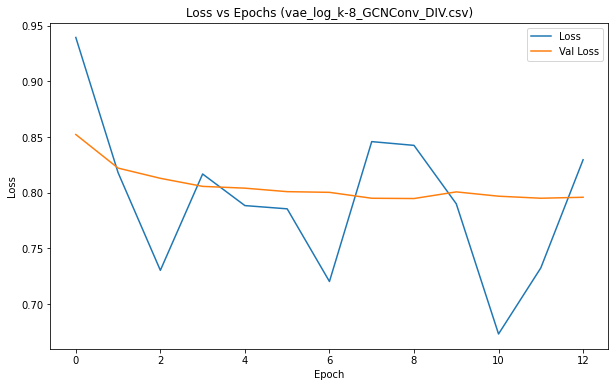

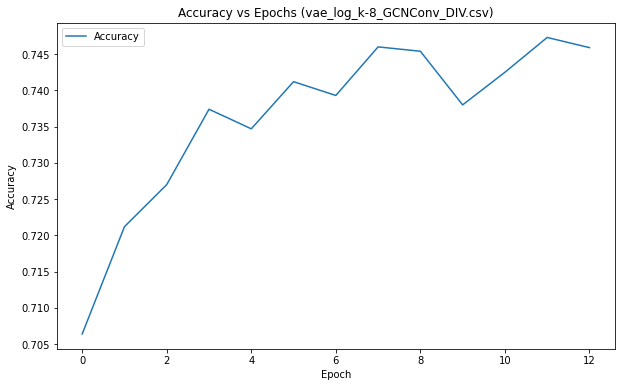

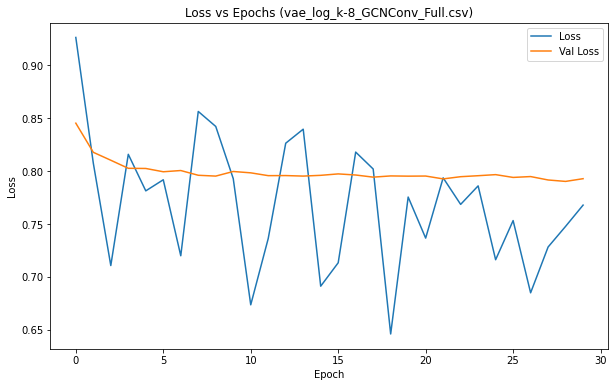

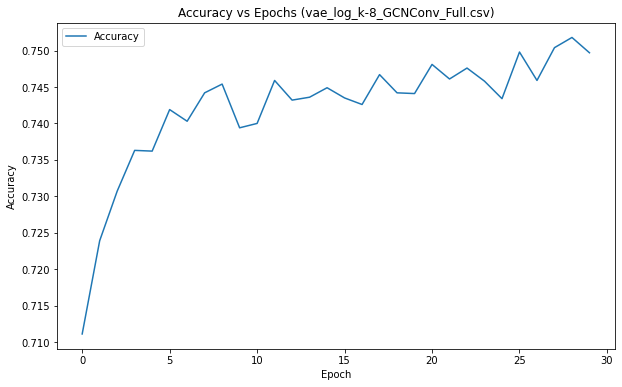

In [22]:

#plot a csv file results as line chartts for each epoch
#load csvs files
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerPatch
from matplotlib.legend import Legend
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import FormatStrFormatter
from glob import glob 
#csv paths
logs = glob("/home/uz1/projects/GCN/vae_log_*_GC*.csv") #+ ["/home/uz1/output/train/20220825-133314-pvig_s_224_gelu-500/ViG.csv"]

#load each csv data from logs
for log in logs :
    df = pd.read_csv(log)
    #change eval_top1 to val_accuracy
    df.rename(columns={'eval_top1':'val_accuracy'},inplace=True)
    df.rename(columns={'eval_loss':'val_loss'},inplace=True)
    df.rename(columns={'train_loss':'loss'},inplace=True)
    #plot loss vs epochs
    plt.figure(figsize=(10,6))
    plt.plot(df['epoch'],df['loss'],label='Loss')
    plt.plot(df['epoch'],df['val_loss'],label='Val Loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Loss vs Epochs ({log.split("/")[-1]})')
    plt.savefig(log+'_loss.png')
    plt.show()
    plt.close()

    # plot acc vs epoch
    plt.figure(figsize=(10,6))
    plt.plot(df['epoch'],df['val_accuracy'],label='Accuracy')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy vs Epochs ({log.split("/")[-1]})')
    plt.savefig(log+'_acc.png')
    plt.show()
    plt.close()

<module 'matplotlib.pyplot' from '/home/uz1/miniconda3/envs/ML/lib/python3.7/site-packages/matplotlib/pyplot.py'>

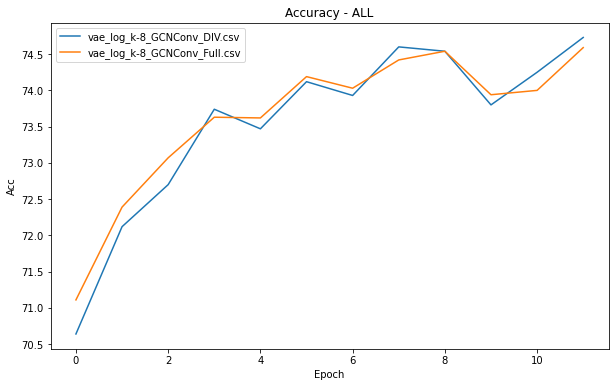

In [24]:
#plot over each other loss with file name as legend
plt.figure(figsize=(10,6))
# use plotly ?
# from plotly import g
for log in logs:
    df = pd.read_csv(log)
    # limit to 1o
    df = df[:12]
    #change eval_top1 to val_accuracy
    df.rename(columns={'eval_top1':'val_accuracy'},inplace=True)
    df.rename(columns={'eval_loss':'val_loss'},inplace=True)
    df.rename(columns={'train_loss':'loss'},inplace=True)

    # if df['val_accuracy] has values under 1 multpy the values by 100
    if df['val_accuracy'].min() < 1:
        df['val_accuracy'] = df['val_accuracy'] * 100
    plt.plot(df['epoch'],df['val_accuracy'],label=log.split("/")[-1])
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Acc')
    plt.title(f'Accuracy - ALL')
    
plt